In [1]:
from fastrenewables.tabular.learner import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.core import *
import pandas as pd
import zipfile
import zipfile, re, os
import numpy as np
from fastai.torch_basics import *
from fastai.metrics import rmse, mae
from fastai.tabular.all import *

In [2]:
def read_single_file(file_name):
    df = pd.read_hdf(file_name, key="powerdata")
    return df

In [3]:
def extract_single_file(path_to_zip_file, directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(path=directory_to_extract_to)

In [4]:
def extract_zip_in_folder(toFolder):
    for root, dirs, files in os.walk(toFolder):
        for filename in files:
            if re.search(r'\.zip$', filename):
                fileSpec = os.path.join(root, filename)
                extract_single_file(fileSpec, root)

In [5]:
def get_wind_speed(x, y):
    z = np.sqrt(x ** 2 + y ** 2)
    return z

def get_wind_direction(x, y):
    z = get_wind_speed(x, y)
    phi = 2 * np.arctan(y / (x + z + 1e-16))
    return phi

In [6]:
def read_csv(file_name):
    df = pd.read_csv(file_name, sep=",")
    df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, infer_datetime_format=True, utc=True)
    df = df.rename(columns={"TIMESTAMP": "TimeUTC", "TARGETVAR": "PowerGeneration", "ZONEID":"TaskID"})
    df.set_index("TimeUTC", inplace=True)
    
    return df

In [7]:
def create_complete_task(file_name_task, file_name_solution=None):
    df = read_csv(file_name_task)
    
    cols = [("U10", "V10"),("U100", "V100")]
        
    for c in cols:
        ws = get_wind_speed(df[c[0]].values, df[c[1]].values)
        wd = get_wind_direction(df[c[0]].values, df[c[1]].values)
        w_height = "100" if "100" in c[0] else "10"
        
        df[f"WindSpeed{w_height}m"] = ws
        df[f"SinWindDirection{w_height}m"] = np.sin(wd)
        df[f"CosWindDirection{w_height}m"] = np.cos(wd)   
    
    df["WindSpeed10m_t_m1"] = df.WindSpeed10m.shift(1).fillna(method='bfill')
    df["WindSpeed10m_t_p1"] = df.WindSpeed10m.shift(-1).fillna(method='ffill')
    
    df["WindSpeed100m_t_m1"] = df.WindSpeed100m.shift(1).fillna(method='bfill')
    df["WindSpeed100m_t_p1"] = df.WindSpeed100m.shift(-1).fillna(method='ffill')
    
    if file_name_solution is not None:
        df_solution = read_csv(file_name_solution)
        df_solution = df_solution[df_solution.TaskID==df.TaskID[0]]
        
#         check if timestamps match
        if (df.index == df_solution.index).sum() == df.shape[0]:
            
            df["PowerGeneration"] = df_solution.PowerGeneration.values
        else:
            raise Warning("Timestamps do not match.")
    df.dropna(inplace=True)
    return df  

In [8]:
def merge_dfs(first_list, second_list):
    dfs = []
    if len(first_list)!= len(second_list):
        raise ValueError("Different lenghts of list.")
        
    for idx in range(len(first_list)):
        df1, df2 = first_list[idx], second_list[idx]
        if df1.TaskID[0] != df2.TaskID[0]:
            raise ValueError("Not sorted correctly. Not matching task ids.")
        dfs.append(pd.concat([df1, df2], axis=0))
        
    return dfs

In [9]:
def prepare_for_tasks(dfs, gefcom_task=1):
    
    start_date = pd.to_datetime("2012-10-01", utc=True) + pd.DateOffset(months=gefcom_task-1)
    end_date = last_day_of_month(start_date)
    
    dfs_train = []
    for df in dfs:
        mask = df.index < start_date
        dfs_train.append(df[mask])
        
    dfs_test = []
    for df in dfs:
        mask = (df.index >= start_date) & (df.index <= end_date)
        dfs_test.append(df[mask])

    return pd.concat(dfs_train, axis=0), pd.concat(dfs_test, axis=0)

In [10]:
import datetime

def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [11]:
# uncomment if file is not yet downloaded

# !wget "https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip"
# extract_single_file("GEFCom2014.zip", "./")
# extract_single_file("GEFCom2014 Data/GEFCom2014-W_V2.zip", "./")
# extract_zip_in_folder("./Wind/")

--2021-09-22 15:46:31--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip [following]
--2021-09-22 15:46:31--  https://www.dropbox.com/s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucddf2d3ad8dd48133645ee8b991.dl.dropboxusercontent.com/cd/0/inline/BWpHvpGaRRMr9pyEcq9UBGRVJaW2BWV48Y0cEXbDjsOSJPani1Oaeqb4n2GVbMVKpw8OdWHsaF9VA645udbisd8HnC79m7sYqYInvX7EzfrTtxqIUqej9LoirX1Z5Kt5Pd6Pw0HM9supOr4lgeFmhNh8/file# [following]
--2021-09-22 15:46:32--  https://ucddf2d3ad8dd48133645ee8b991.dl.dropboxusercontent.com/cd/0/inline/BWpHvpGaRRMr9pyEcq9UBGRVJaW2BWV48Y0cEXbDjsOSJPani1Oaeqb4n2GVbMVKpw8OdWHsaF9VA645u

In [12]:
ls

'GEFCom2014 Data'/   GEFCom2014.zip   gefcom.ipynb   preprocessing.py   Wind/


In [13]:
files_task_15 = !ls {"./Wind/Task\ 15/Task15_W_Zone1_10/*csv"}

In [14]:
dfs_task15 = [create_complete_task(f) for f in files_task_15]

In [15]:
files_task_15_solution = !ls {"./Wind/Task\ 15/TaskExpVars15_W_Zone1_10/*csv"}
dfs_task15_solution = [create_complete_task(f, './Wind/Solution to Task 15/solution15_W.csv') for f in files_task_15_solution]

In [16]:
dfs = merge_dfs(dfs_task15, dfs_task15_solution)

In [17]:
GEFCOM_TASK = 4

In [18]:
df_train, df_test = prepare_for_tasks(dfs, gefcom_task=GEFCOM_TASK)

In [19]:
cat_names = ["TaskID"]

cont_names = ['U10', 'V10', 'U100', 'V100',
       'WindSpeed10m', 'SinWindDirection10m', 'CosWindDirection10m',
       'WindSpeed100m', 'SinWindDirection100m', 'CosWindDirection100m',
       'WindSpeed10m_t_m1', 'WindSpeed10m_t_p1', 'WindSpeed100m_t_m1',
       'WindSpeed100m_t_p1']
y_names = ["PowerGeneration"]


In [20]:
dls = RenewableDataLoaders.from_df(df_train, 
                                   cat_names=cat_names, 
                                   cont_names=cont_names, 
                                   y_names=y_names,
                                   bs=24*10, 
                                   shuffle=True
                                  )

In [21]:
dls.dataset.items.WindSpeed10m.describe()

count    7.026400e+04
mean     6.712153e-18
std      1.000007e+00
min     -2.118351e+00
25%     -7.889739e-01
50%     -1.519718e-01
75%      6.230441e-01
max      5.454891e+00
Name: WindSpeed10m, dtype: float64

In [22]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles=[0.5]):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        
        losses = []

        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(
                torch.max(
                   errors * q, 
                   (-1) * errors * (1-q)
            ).unsqueeze(1))
        loss = torch.cat(losses).mean()

        
        return loss

In [23]:
quantiles = np.arange(0.01,1,0.01)
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [24]:
learn = renewable_learner(dls, 
                          layers=[len(cont_names), 200, 50, 10,  len(quantiles)],
#                           metrics=[rmse, mae], 
                          n_out=len(quantiles), 
                          loss_func=QuantileLoss(quantiles=list(quantiles)))

In [25]:
learn.model

MultiLayerPerceptron(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(11, 6)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (final_activation): Identity()
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=20, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track

In [26]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.158506,0.121201,00:03
1,0.084765,0.083799,00:02
2,0.083962,0.083703,00:03
3,0.083991,0.083656,00:03
4,0.083888,0.083658,00:02


In [27]:
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.083835,0.083675,00:03
1,0.083853,0.083661,00:02
2,0.083953,0.083672,00:02
3,0.083584,0.083687,00:03
4,0.083696,0.083674,00:03
5,0.084150,0.083660,00:03
6,0.083865,0.083640,00:03
7,0.083536,0.083680,00:02
8,0.083806,0.083645,00:02
9,0.083648,0.083676,00:02


In [28]:
to_test = dls.train_ds.new(df_test)
to_test.setup()
to_test.items.WindSpeed100m.describe()

count    7.210000e+03
mean    -1.110531e-16
std      1.000069e+00
min     -2.875503e+00
25%     -6.492170e-01
50%     -4.159524e-03
75%      6.434804e-01
max      4.055518e+00
Name: WindSpeed100m, dtype: float64

In [29]:
dl_test = to_test.dataloaders(shuffle=False, drop_last=False)

In [30]:
yhat = learn.model(torch.tensor(to_test.cats.values).long().to("cuda:0"), torch.tensor(to_test.conts.values).float().to("cuda:0"))
yhat = to_np(yhat)

In [31]:
yhat.shape

(7210, 5)

In [32]:
y = to_test.ys.values

In [33]:
y.shape

(7210, 1)

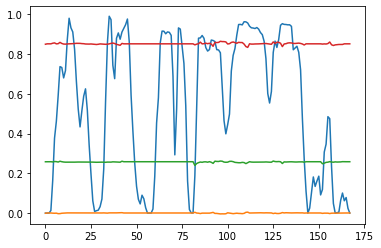

In [34]:
start,end = 0,24*7
plt.plot(y[start:end])
plt.plot(yhat[start:end,0])
plt.plot(yhat[start:end,len(quantiles)//2])
plt.plot(yhat[start:end,-1])
# plt.plot(yhat.reshape(-1, len(quantiles))[start:end,len(quantiles)//2])
# plt.plot(yhat.reshape(-1, len(quantiles))[start:end,-1])

In [35]:
# dl_test.dataset.items["Yhat"] = yhat

In [36]:
# rmse_errors, mae_errors = [],[]
# for k,df in dl_test.dataset.items.groupby("TaskID"):
#     rmse_error = ((df.PowerGeneration-df.Yhat)**2).mean()**0.5
#     mae_error = (df.PowerGeneration-df.Yhat).abs().mean()
#     rmse_errors.append(rmse_error)
#     mae_errors.append(mae_error)
#     print(k,rmse_error, mae_error)

In [37]:
# plt.boxplot(rmse_errors)
# plt.title(f"GEFCOM_TASK {GEFCOM_TASK}")
# plt.show()